<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/HW2_Gradient_descent_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашнее задание: Градиентный спуск — базовые концепции**


В этом домашнем задании вы попрактикуетесь в двух вещах:

1. **Градиентный спуск**
   Вы реализуете базовый GD, закрепите на практике его свойства и научитесь интерпретировать результаты.

2. **Дебаггинг**
   По ходу выполнения заданий вам потребуется выявлять и исправлять ошибки — в паре мест — в программной реализации.

##### **Почему дебаггинг?**

На практике, особенно часто при работе с обучением моделей придется читать ошибки и обеспечивать совместимость своего кода с написанным ранее. При этом, написанный ранее код может быть написан не идеально — не важно LLM его писала или человек.

В этом домашнем задании вы:

* реализуете класс GD с треккингом лосса и градиентов;
* проверите, корректно ли ваш оптимизатор работает на разных функциях (в том числе на не выпуклых!);
* потренируетесь читать графики loss;
* получите много красивых визуализаций;

**Ошибки только в функции для графиков!**

**Дедлайн: 13 декабря 23:59**



In [71]:
  import urllib.request
  import gzip
  import shutil

  urllib.request.urlretrieve(
      'https://math.nist.gov/pub/MatrixMarket2/Harwell-Boeing/lanpro/nos4.mtx.gz',
      'nos4.mtx.gz'
  )
  with gzip.open('nos4.mtx.gz', 'rb') as f_in:
      with open('nos4.mtx', 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)



In [72]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from joblib.testing import param
from plotly.subplots import make_subplots
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.sandbox.mle import grad_calls

np.random.seed(42)

### **Функция для картинок**

Эта функция для красивых графиков. Разберитесь в ее работе (можно - при помощи LLM).

<font color="red">В функции в двух местах преднамеренно допущены ошибки. Исправьте их. </font>

In [73]:
# Эта функция для красивых графиков
def plot_gd_3d(x_range, y_range, Z, loss_fn, history_dict,
               title="Градиентный спуск (3D)", min_point=None):
    """
    3D-график: поверхность + траектории градиентного спуска.

    x_range, y_range : 1D np.array
        Диапазоны по осям x и y.
    Z : 2D np.array
        Значения функции на сетке (len(y_range), len(x_range)).
    loss_fn : callable
        Функция потерь f(params) -> float, чтобы считать z вдоль траекторий.
    history_dict : dict[str, history]
        Словарь: метка -> history, где history['params'] — список параметров.
        Например: {"LR=0.1":gd.history, "LR=0.01": gd2.history}
    min_point : tuple (x*, y*) или None
        Если задано, отмечаем минимум на графике.
    """
    fig = go.Figure()

    # Поверхность функции
    fig.add_trace(
        go.Surface(
            x=x_range,
            y=y_range,
            z=Z,
            opacity=0.7,
            showscale=False
        )
    )

    # Траектории
    # считаются по лоссу
    for label, history in history_dict.items():
        trajectory = np.array(history["params"])  # shape: (T, 2)
        x_traj = trajectory[:, 0]
        y_traj = trajectory[:, 1]
        z_traj = np.array([loss_fn(p) for p in trajectory])

        fig.add_trace(
            go.Scatter3d(
                x=x_traj,
                y=y_traj,
                z=z_traj,
                mode='lines+markers',
                name=label,
                marker=dict(size=4),
                line=dict(width=4)
            )
        )

    # Минимум, если задан
    if min_point is not None:
        x_min, y_min = min_point
        fig.add_trace(
            go.Scatter3d(
                x=[x_min],
                y=[y_min],
                z=[loss_fn(np.array([x_min, y_min]))],
                mode='markers',
                name='Минимум',
                marker=dict(size=6, symbol='diamond-open')
            )
        )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="f(x, y)"
        ),
        height=700
    )

    fig.show()


def plot_gd_2d(x_range, y_range, Z, history_dict,
               title="Градиентный спуск (2D контуры)",
               start_points=None, min_point=None,
               contour_kwargs=None):
    """
    2D-контуры + траектории градиентного спуска.

    x_range, y_range : 1D np.array
    Z : 2D np.array
    history_dict : dict[str, history]
        метка -> history, где history['params'] — список параметров.
    start_points : list[np.array] или None
        Список стартовых точек (x0, y0), чтобы нарисовать их на графике.
    min_point : tuple (x*, y*) или None
        Если задано, отмечаем минимум.
    contour_kwargs : dict или None
        Доп. параметры для go.Contour (contours=..., opacity=..., ...).
    """
    if contour_kwargs is None:
        contour_kwargs = dict(
            colorscale='Viridis',
            showscale=False,
            contours=dict(start=0, end=30, size=2),
            opacity=0.7
        )

    fig = go.Figure()

    # Контурный график функции
    fig.add_trace(
        go.Contour(
            x=x_range,
            y=y_range,
            z=Z,
            **contour_kwargs
        )
    )

    # Траектории
    for label, history in history_dict.items():
        trajectory = np.array(history["params"])
        fig.add_trace(
            go.Scatter(
                x=trajectory[:, 0],
                y=trajectory[:, 1],
                mode='lines+markers',
                name=label,
                marker=dict(size=5),
                line=dict(width=3)
            )
        )

    # Стартовые точки (если переданы отдельно)
    # точка имеет
    if start_points is not None:
        for i, p0 in enumerate(start_points):
            fig.add_trace(
                go.Scatter(
                    x=[p0[0]],
                    y=[p0[1]],
                    mode='markers',
                    name=f'Start {i+1}',
                    marker=dict(size=10, symbol='x')
                )
            )

    # Минимум
    if min_point is not None:
        x_min, y_min = min_point
        fig.add_trace(
            go.Scatter(
                x=[x_min],
                y=[y_min],
                mode='markers',
                name='Минимум',
                marker=dict(size=10, symbol='diamond-open')
            )
        )

    fig.update_layout(
        title=title,
        xaxis_title="x",
        yaxis_title="y",
        height=700
    )

    fig.show()

In [74]:
print(
'''
Ошибка 1 — в функции plot_gd_3d:
z_traj = np.array([x_range(p) for p in trajectory])
x_range — это массив, а не функция. Должно быть:
z_traj = np.array([loss_fn(p) for p in trajectory])

  ---
Ошибка 2 — в функции plot_gd_2d (в блоке стартовых точек):
y=[p0[0]],
Для координаты y используется индекс [0] вместо [1]. Должно быть:
y=[p0[1]],
''')


Ошибка 1 — в функции plot_gd_3d:
z_traj = np.array([x_range(p) for p in trajectory])
x_range — это массив, а не функция. Должно быть:
z_traj = np.array([loss_fn(p) for p in trajectory])

  ---
Ошибка 2 — в функции plot_gd_2d (в блоке стартовых точек):
y=[p0[0]],
Для координаты y используется индекс [0] вместо [1]. Должно быть:
y=[p0[1]],



### **Задание 1. Градиентный спуск: постановка задачи (3 балла)**


Напомним, что в задачах машинного обучения мы хотим минимизировать **функцию потерь**
$$L(w): \mathbb{R}^d \to \mathbb{R},$$
где $w \in \mathbb{R}^d$ — вектор параметров модели (веса), а $L$ измеряет качество этой модели на данных. Пострейший пример функции потерь — MSE потери. Если мы обозначим за $y_i$ истинный прогноз, а за $\hat{y}$ — предсказанный моделью, то MSE — функция вида:

$$L(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (y - \hat{y})^2$$

Если функция потерь дифференцируема, один из базовых численных методов для её минимизации — **градиентный спуск** (Gradient Descent). Если же функция потерь дифференцируема не везде — мы используем в "плохих точках" [субградиент](https://www.google.com/search?client=safari&rls=en&q=%D0%A1%D1%83%D0%B1%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82&ie=UTF-8&oe=UTF-8).

#### **Идея метода градиетного спуска**

Градиент $\nabla L(w)$ по определению показывает направление **наискорейшего роста** функции. Чтобы уменьшать значение $L(w)$, нужно двигаться в противоположную сторону — туда, где функция убывает:

$$w_{k+1} = w_k - \eta \nabla L(w_k),$$

где

* $w_k$ — параметры на итерации $k$,
* $\eta > 0$ — шаг обучения (learning rate),
* $\nabla L(w_k)$ — градиент функции потерь по параметрам $w$ в точке $w_k$.

При достаточно «хороших» свойствах $L(w)$ (выпуклость — можно обозвать это "парабольным" поведением и гладкость — дифференцируемость везде) и правильно подобранном шаге $\eta$ последовательность ${w_k}$ будет стремиться к точке минимума. На практике, свойства функции мы проверяем не всегда, так как используем золотой набор функций устоявшийся в области и ключевую роль играет шаг $\eta$.

#### **Детали? Детали!**

При реализации градиентного спуска нужно учитывать:

1. **Инициализацию**

   Необходимо задать начальное значение параметров $w_0$.

2. **Шаг обучения $\eta$**

     Его правильный подбор — это искусство.

3. **Критерии остановки**

   Обычно метод выполняется фиксированное число итераций $N$, либо пока не выполнится одно из условий:

   * $|\nabla L(w_k)|$ стало достаточно малым;
   * изменение параметров $|w_{k+1} - w_k|$ мало;
   * изменение значения потерь $|L(w_{k+1}) - L(w_k)|$ мало.

4. **История обучения**

   Для анализа работы алгоритма полезно сохранять:

   * значения параметров $w_k$ на каждой итерации;
   * значения функции потерь $L(w_k)$;
   * (не обязательно, но полезно) значения нормы градиента $|\nabla L(w_k)|$.

    Эта информация позволит визуализировать траекторию спуска и поведение loss-функции во времени. Когда у нас есть этот график (да и вообще все 3 из перечисленных), мы можем понимать, как у обучения дела.


#### **1. Выпуклость и нет (1.5 балла)**

Из теории мы также знаем, что хочется минимизировать **выпуклые функции**. Почему именно их? Они приятные и у них:

* либо один глобальный минимум,
* либо целое выпуклое множество глобальных минимумов,
* нет локальных минимумов.

Это означает, что при разумном шаге градиентный спуск, стартуя из любой точки, будет стремиться к глобальному минимуму.

Формально, функция $f:\mathbb{R}^d \to \mathbb{R}$ называется **выпуклой**, если для любых $x, y \in \mathbb{R}^d$ и $\lambda \in [0, 1]$:
$$f(\lambda x + (1-\lambda) y) \leq \lambda f(x) + (1-\lambda) f(y)$$

Для дважды дифференцируемых функций это эквивалентно тому, что их **матрица Гессе** (матрица вторых производных) неотрицательно определена во всех точках.

Но это всё детали. Которые полезно знать. Но в реальных задачах машинного обучения мы почти всегда сталкиваемся с **невыпуклыми** функциями потерь.

Уметь понимать поведение на выпуклом и невыпуклом ландшафте по лоссу/градиенту важно, потому что это поможет вам в будущем изучать графики ваших моделей более четко и понимать, почему обучение застряло и что с этим можно сделать (добавить инерцию, перестартануть с других точек и так далее). Что же, давайте знакомиться с разным поведением!

#### **1. 1. Задание: реализуйте в коде функции и их градиенты**

1. **Простая квадратичная функция** (выпуклая):
   
   $f(x, y) = x^2 + y^2.$

2. **Функция Розенброка ([Rosenbrock's banana function](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A0%D0%BE%D0%B7%D0%B5%D0%BD%D0%B1%D1%80%D0%BE%D0%BA%D0%B0))**:

   $f_{\text{R}}(x, y) = (a - x)^2 + b(y - x^2)^2$, тут по умолчанию a=1, b=100, но далее надо реализовывать a и b как гиперпараметры.

Мы будем использовать эти функции дальше для визуализации траекторий градиентного спуска, сравнения влияния шага обучения и анализа ландшафта.

**Ваши задачи в этом подпункте:**

1. Реализовать функции:

   * `quadratic_loss(params)`
   * `rosenbrock_loss(params, a=1, b=100)`

2. Реализовать их градиенты:

   * `quadratic_grad(params)` — возвращает `[grad_x, grad_y]`
   * `rosenbrock_grad(params, a=1, b=100)` — возвращает `[grad_x, grad_y]`


Дальше эти функции будут использоваться в классе `GradientDescent` для экспериментов с разными значениями шага обучения и для 2D/3D визуализаций ландшафта.



In [75]:
# Квадратичная функция
def quadratic_loss(params):
    """
    params: list — список, вида [x, y]
    f(x, y) = x^2 + y^2
    """
    x, y = params
    return x**2 + y**2

def quadratic_grad(params):
    """Градиент"""
    x, y = params
    return np.array([2*x, 2*y])

# Функция Розенброка
def rosenbrock_loss(params, a=1, b=100):
    """
    params: list — список, вида [x, y]
    f(x, y) = (a - x)^2 + b(y - x^2)^2
    """
    x, y = params
    return (a - x)**2 + b*(y - x**2)**2

def rosenbrock_grad(params, a=1, b=100):
    """Градиент функции Розенброка"""
    x, y = params
    grad_x = -2*(a - x) - 4*b*x*(y - x**2)
    grad_y = 2*b*(y - x**2)
    return np.array([grad_x, grad_y])


#### **1. 2. Реализуйте классический (ванильный) градиентный спуск (1.5 балла)**

Теперь давайте сделаем **класс градиентного спуска** `GradientDescent`, в котором будет помимо прочего реализовано подробное логирование. Все параметры, которые класс принимает на вход, описаны ниже и соответствуют теоретической постановке задачи.

In [76]:
class GradientDescent:

    """Ваш класс для базовой реализации градиентного спуска
    learning_rate: float - скорость спуска
    n_iterations: int - максимальное количество итераций спуска
    history: dict - словарь, который будет хранить историю обучения
    """

    # Ваш код здесь
    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.history = {
            'params': [],
            'loss': [],
            'gradients': []
        }

    def fit(self, loss_fn, grad_fn, initial_params):
        """
        Обучение с помощью GD

            loss_fn: функция потерь
            grad_fn: функция градиента
            initial_params: начальные параметры
        """
        params = initial_params.copy()

        for i in range(self.n_iterations):
            grad = grad_fn(params)
            loss = loss_fn(params)

            # Сохраняем историю
            self.history['params'].append(params.copy())
            self.history['loss'].append(float(loss))
            self.history['gradients'].append(np.array(grad))

            # Обновляем параметры
            params = params - self.learning_rate*grad

        # Сохраняем финальное состояние
        final_grad = grad_fn(params)
        final_loss = loss_fn(params)
        self.history['params'].append(params.copy())
        self.history['loss'].append(float(final_loss))
        self.history['gradients'].append(np.array(final_grad))

        return params


In [77]:
# Тестируем визуализацию на квадратичной функции
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + Y**2

# Запускаем градиентный спуск
gd = GradientDescent(learning_rate=0.1, n_iterations=50)
gd.fit(quadratic_loss, quadratic_grad, np.array([1.5, 1.5]))

# Рисуем 3D график
plot_gd_3d(
  x_range=x_range,
  y_range=y_range,
  Z=Z,
  loss_fn=quadratic_loss,
  history_dict={"LR=0.1": gd.history},
  title="Квадратичная функция: тест GD",
  min_point=(0.0, 0.0)
)

Теперь проверим работоспособность функций, но если вы сделали это выше при реализации — вам только плюсы!

Мы будем использовать библиотеку plotly, чтобы получить функциональные графики — которые можно приближать, отдалять, крутить и так далее. Нарисуем полученные функции в 3D и протестируем градиентный спуск. Вернее, его параметры.

### **Задание 2. Анализ гиперпараметров градиетного спуска (2 балла)**


Learning rate (в разных нотациях его обозначают за $\eta или \alpha$) — основной гиперпараметр градиетного спуска и любой его модификации. Даже для простой выпуклой функции (например, квадратичной) заведомо неверный выбор шага делает обучение неэффективным или просто расходящимся.


Давайте проанализруем влияние шага обучения на поведение градиентного спуска.
Для этого:

1. Возьмите несколько значений learning rate:
   $$\eta \in \{0.001,\ 0.01,\ 0.1,\ 0.5,\ 1.0\}.$$

2. Возьмите несколько стартовых точек.
   
3. Протестируйте работу реализованного класса работу на двух функциях:

   * выпуклой функции
     $$f(x, y) = x^2 + y^2,$$
   * невыпуклой функции Розенброка
     $$f(x, y) = (1 - x)^2 + 100 (y - x^2)^2$$
4. Сделайте выводы.


In [78]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
initial_points = [np.array([1.0, 1.0]), np.array([-1.5, 1.5]), np.array([1.8, -1.0])]

# Сетка для визуализации функции
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + Y**2  # квадратичная поверхность

results_lr_quadr = {}

# Запускаем градиентный спуск для всех LR и стартовых точек
for lr in learning_rates:
    for i, initial_point in enumerate(initial_points):
        gd = GradientDescent(learning_rate=lr, n_iterations=100)
        gd.fit(quadratic_loss, quadratic_grad, initial_point.copy())
        final_params = gd.history["params"][-1]
        results_lr_quadr[f'LR={lr}, start{i+1}'] = gd.history

        print(f"LR={lr}, start{i+1}: loss={quadratic_loss(final_params):.6f}, "
              f"params=[{final_params[0]:.4f}, {final_params[1]:.4f}]")

LR=0.001, start1: loss=1.340103, params=[0.8186, 0.8186]
LR=0.001, start2: loss=3.015232, params=[-1.2279, 1.2279]
LR=0.001, start3: loss=2.841019, params=[1.4734, -0.8186]
LR=0.01, start1: loss=0.035176, params=[0.1326, 0.1326]
LR=0.01, start2: loss=0.079146, params=[-0.1989, 0.1989]
LR=0.01, start3: loss=0.074573, params=[0.2387, -0.1326]
LR=0.1, start1: loss=0.000000, params=[0.0000, 0.0000]
LR=0.1, start2: loss=0.000000, params=[-0.0000, 0.0000]
LR=0.1, start3: loss=0.000000, params=[0.0000, -0.0000]
LR=0.5, start1: loss=0.000000, params=[0.0000, 0.0000]
LR=0.5, start2: loss=0.000000, params=[0.0000, 0.0000]
LR=0.5, start3: loss=0.000000, params=[0.0000, 0.0000]
LR=1.0, start1: loss=2.000000, params=[1.0000, 1.0000]
LR=1.0, start2: loss=4.500000, params=[-1.5000, 1.5000]
LR=1.0, start3: loss=4.240000, params=[1.8000, -1.0000]


In [86]:
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=quadratic_loss,
    history_dict=results_lr_quadr,
    title="Квадратичная функция: траектории GD (3D)",
    min_point=(0.0, 0.0)
)

plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=results_lr_quadr,
    title="Квадратичная функция: траектории GD (2D контуры)",
    start_points=initial_points,
    min_point=(0.0, 0.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=30, size=2),
        opacity=0.7
    )
)

In [87]:
# Сетка для визуализации функции Розенброка
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Маленькие learning rates (большие вызывают overflow)
learning_rates_rosen = [0.0005, 0.001, 0.002]
initial_points = [np.array([-0.5, 0.5]), np.array([0.0, 0.0]), np.array([-1.0, 1.0])]

results_lr_banna = {}

# Много итераций для Розенброка
for lr in learning_rates_rosen:
    for i, initial_point in enumerate(initial_points):
        gd = GradientDescent(learning_rate=lr, n_iterations=3000)
        gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point.copy())
        final_rosen = gd.history['params'][-1]
        results_lr_banna[f'LR={lr}, start{i+1}'] = gd.history

        print(f"Final Rosenbrock loss = {rosenbrock_loss(final_rosen):.6f}, "
              f"Final params = [{final_rosen[0]:.4f}, {final_rosen[1]:.4f}]")

Final Rosenbrock loss = 0.086900, Final params = [0.7055, 0.4964]
Final Rosenbrock loss = 0.055832, Final params = [0.7640, 0.5826]
Final Rosenbrock loss = 0.150665, Final params = [0.6123, 0.3730]
Final Rosenbrock loss = 0.016237, Final params = [0.8727, 0.7610]
Final Rosenbrock loss = 0.011560, Final params = [0.8926, 0.7962]
Final Rosenbrock loss = 0.023826, Final params = [0.8458, 0.7147]
Final Rosenbrock loss = 0.001104, Final params = [0.9668, 0.9346]
Final Rosenbrock loss = 0.000824, Final params = [0.9713, 0.9434]
Final Rosenbrock loss = 0.001525, Final params = [0.9610, 0.9233]


In [88]:
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=rosenbrock_loss,
    history_dict=results_lr_banna,
    title="Rosenbrock функция: траектории GD (3D)",
    min_point=(1.0, 1.0)
)

plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=results_lr_banna,
    title="Rosenbrock функция: траектории GD (2D контуры)",
    start_points=initial_points,
    min_point=(1.0, 1.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=30, size=2),
        opacity=0.7
    )
)

**Выводы:**

**1. Квадратичная функция (выпуклая):**
- Градиентный спуск стабильно сходится к минимуму (0, 0) из любой стартовой точки
- Большие learning rates (0.1-0.5) обеспечивают быструю сходимость
- При lr=1.0 наблюдаются осцилляции — шаг слишком большой
- Стартовая точка не влияет на конечный результат — все траектории приходят в минимум

**2. Функция Розенброка (невыпуклая):**
- Функция имеет очень крутые градиенты из-за коэффициента b=100
- Большие learning rates (>0.005) вызывают overflow и расходимость (nan)
- Требуются маленькие lr (0.0005-0.002) и много итераций (3000+)
- Сходимость медленная из-за узкой изогнутой "долины" функции
- Даже после 3000 итераций алгоритм не достигает точного минимума (1, 1)

**3. Общие выводы о learning rate:**
- Слишком большой lr → расходимость или осцилляции
- Слишком маленький lr → очень медленная сходимость
- Оптимальный lr зависит от "ландшафта" функции потерь
- Для сложных невыпуклых функций нужен более консервативный (маленький) lr
- Выпуклые функции более "прощающие" к выбору гиперпараметров

### **Задание 3. Анализ Losses (2 балла)**

Реализованный вами класс также сохранял графики loss-функции. Их в процессе обучения мы также анализируем. Говорят, что **loss “сходится”**, если выполняются следующие признаки:

1. Значение loss $L(w_k)$ монотонно убывает и приближается к некоторому предельному значению (выходит на плато):
   $$|L(w_{k+1}) - L(w_k)| \to 0$$

Сошелся ли лосс у нас? Для ответы используйте реализованные вами методы из заданий 1–2:

1. **Постройте графики значения loss по итерациям** для:

   * квадратичной функции,
   * функции Розенброка,
   * для всех значений learning rate, что и в заданиях выше ($\eta \in \{0.001, 0.01, 0.1, 0.5\}$).

2. **В каждой серии экспериментов**:

   * сравните, как меняется форма графика loss при разных $\eta$;
   * отметьте, где кривая loss ведёт себя “хорошо” (гладкое убывание) и где “плохо” (скачки, рост, колебания, плато).
   * где мы сошлись, а где — нет.

3. **Проанализируйте различия** между функциями.



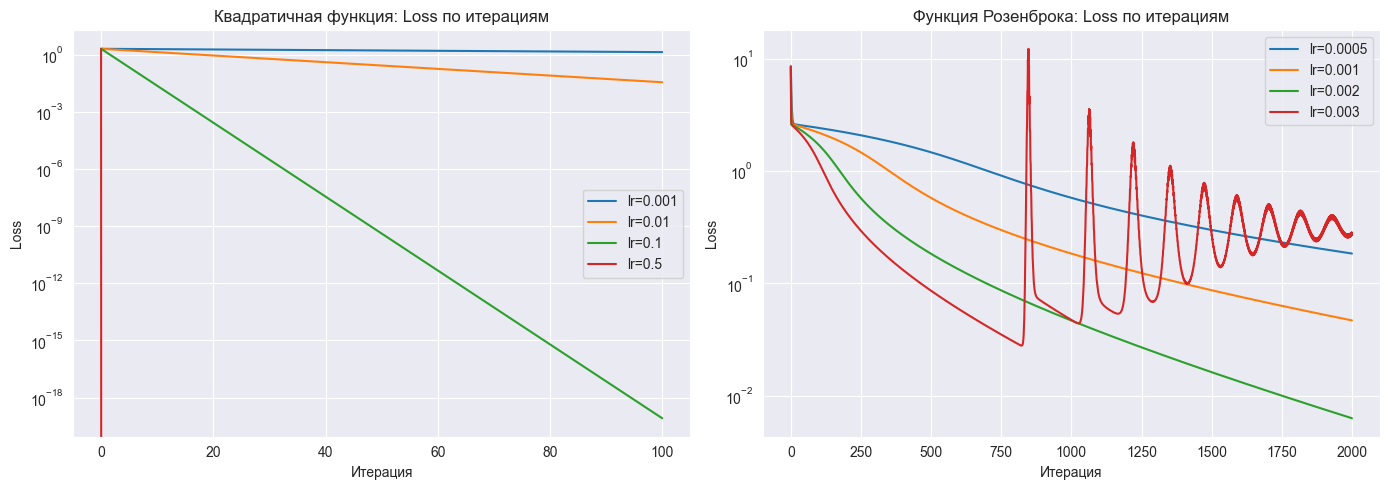

АНАЛИЗ СХОДИМОСТИ

--- Квадратичная функция ---
lr=0.001: final_loss=1.34e+00, diff=5.38e-03 -> НЕ СОШЕЛСЯ
lr=0.01: final_loss=3.52e-02, diff=1.45e-03 -> НЕ СОШЕЛСЯ
lr=0.1: final_loss=8.30e-20, diff=4.67e-20 -> СОШЕЛСЯ
lr=0.5: final_loss=0.00e+00, diff=0.00e+00 -> СОШЕЛСЯ

--- Функция Розенброка ---
lr=0.0005: final_loss=0.1841, diff=1.59e-04 -> НЕ СОШЕЛСЯ
lr=0.001: final_loss=0.0468, diff=5.41e-05 -> НЕ СОШЕЛСЯ
lr=0.002: final_loss=0.0063, diff=1.15e-05 -> СОШЕЛСЯ (почти)
lr=0.003: final_loss=0.2691, diff=1.56e-02 -> НЕ СОШЕЛСЯ


In [96]:
# Графики loss по итерациям

learning_rates_plot = [0.001, 0.01, 0.1, 0.5]
initial_point_quadr = np.array([1.0, 1.0])
initial_point_rosen = np.array([-0.5, 0.5])

# === Квадратичная функция ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Левый график - квадратичная
ax1 = axes[0]
for lr in learning_rates_plot:
    gd = GradientDescent(learning_rate=lr, n_iterations=100)
    gd.fit(quadratic_loss, quadratic_grad, initial_point_quadr.copy())
    ax1.plot(gd.history['loss'], label=f'lr={lr}')

ax1.set_xlabel('Итерация')
ax1.set_ylabel('Loss')
ax1.set_title('Квадратичная функция: Loss по итерациям')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True)

# Правый график - Розенброка (маленькие lr, больше итераций)
ax2 = axes[1]
learning_rates_rosen_plot = [0.0005, 0.001, 0.002, 0.003]
for lr in learning_rates_rosen_plot:
    gd = GradientDescent(learning_rate=lr, n_iterations=2000)
    gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point_rosen.copy())
    ax2.plot(gd.history['loss'], label=f'lr={lr}')

ax2.set_xlabel('Итерация')
ax2.set_ylabel('Loss')
ax2.set_title('Функция Розенброка: Loss по итерациям')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True)

plt.tight_layout()
plt.show()

# === Анализ сходимости ===
print("=" * 60)
print("АНАЛИЗ СХОДИМОСТИ")
print("=" * 60)

print("\n--- Квадратичная функция ---")
for lr in learning_rates_plot:
    gd = GradientDescent(learning_rate=lr, n_iterations=100)
    gd.fit(quadratic_loss, quadratic_grad, initial_point_quadr.copy())
    final_loss = gd.history['loss'][-1]
    loss_diff = abs(gd.history['loss'][-1] - gd.history['loss'][-2])
    
    if final_loss < 1e-6:
        status = "СОШЕЛСЯ"
    elif loss_diff < 1e-6:
        status = "ПЛАТО"
    else:
        status = "НЕ СОШЕЛСЯ"
    
    print(f"lr={lr}: final_loss={final_loss:.2e}, diff={loss_diff:.2e} -> {status}")

print("\n--- Функция Розенброка ---")
for lr in learning_rates_rosen_plot:
    gd = GradientDescent(learning_rate=lr, n_iterations=2000)
    gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point_rosen.copy())
    final_loss = gd.history['loss'][-1]
    loss_diff = abs(gd.history['loss'][-1] - gd.history['loss'][-2])
    
    if final_loss < 0.01:
        status = "СОШЕЛСЯ (почти)"
    elif loss_diff < 1e-6:
        status = "ПЛАТО"
    else:
        status = "НЕ СОШЕЛСЯ"
    
    print(f"lr={lr}: final_loss={final_loss:.4f}, diff={loss_diff:.2e} -> {status}")

**Ваши выводы здесь.**

### **Задание 4. Расписания для learning rate и победа над бананами (3 балла)**

В предыдущих заданиях мы рассматривали градиентный спуск с постоянным шагом обучения

$$w_{k+1} = w_k - \eta\nabla L(w_k),$$
где $\eta$ (learning rate) — фиксированная константа. Но графики функций выше вблизи минимумов наталкивают на ледующую интуицию (встречающуюся очень часто) —  в начале обучения продуктивнее делать большие шаги, чтобы быстро “спуститься” с вершины/плато, ближе к минимуму шаг нужно уменьшать, чтобы не перепрыгнуть минимум.

Чтобы реализовать эту идею, на практике почти всегда используют расписание для шага обучения (learning rate schedules): $\eta$ делают зависящим от номера итерации:

$$\eta_k = \eta(k), \quad k = 0, 1, 2, \dots$$

Даже в самых сложных модификациях градиентного спуска (Momentum, Adam, Adagrad, RMSProp и т.п.) всегда есть базовый learning rate ((\eta), (\alpha)) и “соседние” гиперпараметры, которые управляют эффективным шагом, так что идея “шаг со временем меняется” присутствует всегда, даже если она спрятана в более сложной формуле.

**Варианты расписаний:**

1. **Step decay (ступенчатое уменьшение):**
   $$
   \eta_k =
   \begin{cases}
   \eta_0, & k < k_1, \\
   \eta_0 \cdot \gamma, & k_1 \le k < k_2 \\
   \eta_0 \cdot \gamma^2, & k \ge k_2.
   \end{cases}
   $$

2. **Exponential decay:**
   
   $$\eta_k = \eta_0 \cdot \gamma^k, \quad 0 < \gamma < 1.$$

3. **Inverse time decay:**
   $$\eta_k = \frac{\eta_0}{1 + \lambda k}.$$

и на самом деле — безумно много других — cosine decay, warm restarts и т.п.. Вам не нужно их заучивать, но важно их знать, чтобы понимать, как улучшать свои решения. Поэтому давайте сделаем простое расписание своими руками.

#### **4.1 Реализация расписания (1.5 балла)**

1. **Модифицируйте класс `GradientDescent`** так, чтобы он поддерживал **расписание шага обучения — inverse time decay**.



In [97]:
class GradientDescentWithScheduler:
    """
    Градиентный спуск с опциональным расписанием learning rate.

    Параметры
    ---------
    learning_rate : float — базовый шаг обучения η_0.
    n_iterations : int — число итераций.
    decay : float или None
        если decay is None — шаг обучения постоянный: η_k = η_0.
        если decay > 0 — inverse time decay:
            η_k = η_0 / (1 + decay * k),
        где k — номер итерации (0, 1, 2, ...).
    """

    def __init__(self, learning_rate=0.01, n_iterations=100, decay=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.decay = decay
        self.history = {
            'params': [],
            'loss': [],
            'gradients': [],
            'learning_rates': []  # сохраняем lr на каждой итерации
        }

    def get_lr(self, k):
        """Вычисляет learning rate на итерации k"""
        if self.decay is None:
            return self.learning_rate
        else:
            # Inverse time decay: η_k = η_0 / (1 + decay * k)
            return self.learning_rate / (1 + self.decay * k)

    def fit(self, loss_fn, grad_fn, initial_params):
        """
        Обучение с помощью GD с расписанием lr.
        
        Возвращает финальные параметры.
        """
        params = initial_params.copy()

        for k in range(self.n_iterations):
            grad = grad_fn(params)
            loss = loss_fn(params)
            lr_k = self.get_lr(k)

            # Сохраняем историю
            self.history['params'].append(params.copy())
            self.history['loss'].append(float(loss))
            self.history['gradients'].append(np.array(grad))
            self.history['learning_rates'].append(lr_k)

            # Обновляем параметры с текущим lr
            params = params - lr_k * grad

        # Сохраняем финальное состояние
        final_grad = grad_fn(params)
        final_loss = loss_fn(params)
        self.history['params'].append(params.copy())
        self.history['loss'].append(float(final_loss))
        self.history['gradients'].append(np.array(final_grad))
        self.history['learning_rates'].append(self.get_lr(self.n_iterations))

        return params

#### **4.2 Победа над сложным минимумом (1.5 балла)**

1. **Сравните поведение градиентного спуска с постоянным lr и с расписанием lr** на функции Розенброка:

   * стартуйте из точки, фиксированной в коде с фиксрованным lr
   * запустите:

     * градиентный спуск с **постоянным** шагом $η = η_0$;
     * градиентный спуск с **убывающим** шагом $η_k$ (exponential decay или inverse time decay).

2. **Для каждого варианта:**

   * постройте 2D-контурный график функции Розенброка с траекторией;
   * постройте 3D-график ландшафта с траекторией;
   * постройте график значения loss по итерациям.

3. **Сделайте выводы. Опишите всё, что вы поняли о спуске из заданий.**

In [99]:
initial_point = np.array([0.3, 3])

# Подберите для этой точки оптимальный decay и lr, чтобы получить ошибку с расписанием < 0.05
lr = 0.001
decay = 0.001

# Постоянный learning rate
gd_const = GradientDescentWithScheduler(learning_rate=lr, n_iterations=5000, decay=None)
final_const = gd_const.fit(rosenbrock_loss, rosenbrock_grad, initial_point.copy())

# Убывающий learning rate (inverse time decay)
gd_decay = GradientDescentWithScheduler(learning_rate=lr*5, n_iterations=5000, decay=decay)
final_decay = gd_decay.fit(rosenbrock_loss, rosenbrock_grad, initial_point.copy())

print("Постоянный lr:", final_const, "loss =", rosenbrock_loss(final_const))
print("Inverse time decay:", final_decay, "loss =", rosenbrock_loss(final_decay))

Постоянный lr: [1.08804122 1.18416783] loss = 0.007762420554144479
Inverse time decay: [nan nan] loss = nan


/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_43794/429122262.py:27: RuntimeWarning:

overflow encountered in scalar multiply

/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_43794/429122262.py:22: RuntimeWarning:

overflow encountered in scalar power

/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_43794/4291574717.py:55: RuntimeWarning:

invalid value encountered in subtract



In [ ]:
# Сетка для визуализации Розенброка
x_range = np.linspace(-2, 2, 300)
y_range = np.linspace(-1, 4, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Истории для наших двух вариантов GD
history_dict = {
    "Постоянный lr": gd_const.history,
    "Inverse time decay": gd_decay.history
}

# === 1. 2D-контуры + траектории ===
plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=history_dict,
    title="Функция Розенброка: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(1.0, 1.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=500, size=25),
        opacity=0.7
    )
)

# === 2. 3D-поверхность + траектории ===
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=rosenbrock_loss,
    history_dict=history_dict,
    title="Функция Розенброка: траектории GD (3D ландшафт)",
    min_point=(1.0, 1.0)
)

# === 3. График Loss по итерациям ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(gd_const.history['loss'], label='Постоянный lr', alpha=0.8)
ax.plot(gd_decay.history['loss'], label='Inverse time decay', alpha=0.8)

ax.set_xlabel('Итерация')
ax.set_ylabel('Loss')
ax.set_title('Сравнение сходимости: постоянный lr vs inverse time decay')
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()

# Финальные результаты
print("=" * 60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print("=" * 60)
print(f"Постоянный lr:      loss = {gd_const.history['loss'][-1]:.6f}, params = {final_const}")
print(f"Inverse time decay: loss = {gd_decay.history['loss'][-1]:.6f}, params = {final_decay}")
print(f"Истинный минимум:   loss = 0.000000, params = [1.0, 1.0]")

**Общие выводы:**

**1. Сравнение постоянного lr и inverse time decay:**
- **Постоянный lr** — требует очень маленького шага для стабильности, из-за чего сходимость медленная
- **Inverse time decay** — позволяет начать с большего шага (быстрее спуститься с плато), а затем уменьшать шаг для точной настройки вблизи минимума

**2. Поведение на функции Розенброка:**
- Функция имеет узкую изогнутую "долину" с крутыми склонами
- Большие lr вызывают overflow из-за огромных градиентов (b=100)
- Расписание lr помогает: в начале большие шаги → быстрое продвижение, в конце маленькие → стабильная сходимость

**3. Практические выводы о градиентном спуске:**
- **Выбор lr критичен**: слишком большой → расходимость, слишком маленький → медленная сходимость
- **Выпуклые функции** (квадратичная) — "прощают" ошибки в выборе lr, сходятся из любой точки
- **Невыпуклые функции** (Розенброка) — требуют тщательного подбора гиперпараметров
- **Расписания lr** — практически всегда улучшают сходимость на сложных функциях
- **Число итераций** — для сложных функций может потребоваться значительно больше итераций

**4. Что важно для практики ML:**
- Всегда начинать с небольшого lr и постепенно увеличивать
- Использовать расписания (decay) для стабильной сходимости
- Мониторить график loss — он показывает, сходится ли модель
- Современные оптимизаторы (Adam, RMSProp) автоматически адаптируют lr

## **Бонус 0.25 балла**

Проанализируйте график лосс-функции ниже. Попробуйте сформулировать гипотезы:
- Что происходит?
- Что с этим делать?

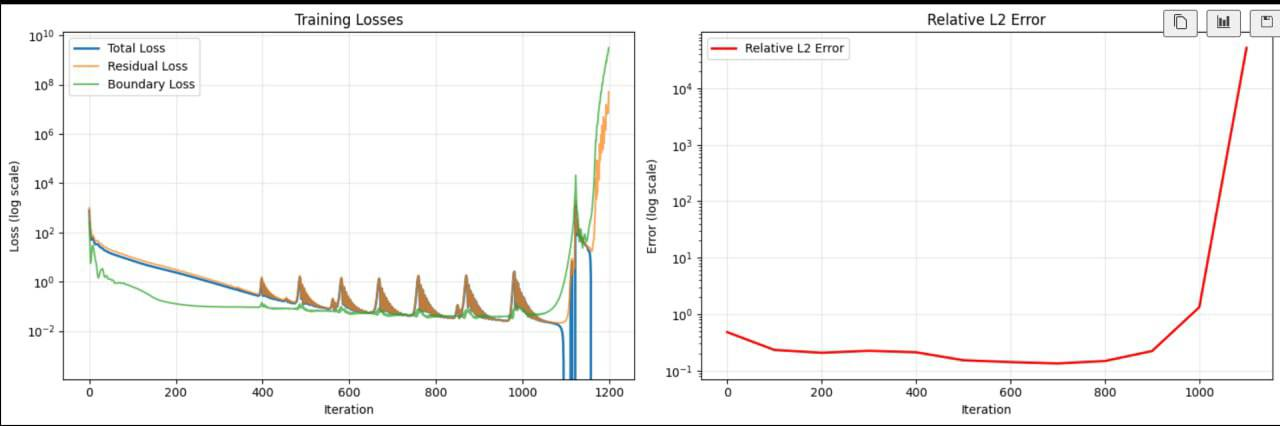